https://youtu.be/3yk9sBja7YI

Training custom models for segmentation using StarDist

In [1]:
!pip install stardist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 10.0 MB/s eta 0:00:00


In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
#matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [3]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [4]:
#Read input image and corresponding mask names
X = sorted(glob('/content/input.tif'))
Y = sorted(glob('/content/input_lab.tif'))


In [5]:
#Read input image and corresponding mask names
X = sorted(glob('/content/input.tif'))
Y = sorted(glob('/content/input_lab.tif'))

import numpy as np
def slice_numpy_array(image_array):
    # Get the shape of the original array
    height, width = image_array.shape

    # Ensure that both dimensions are divisible by 16
    new_height = height - (height % 16)
    new_width = width - (width % 16)
    image_array = image_array[:new_height, :new_width]

    # Calculate the dimensions of each slice
    slice_height = new_height // 3
    slice_width = new_width // 3

    # List to store the sliced arrays
    sliced_arrays = []

    # Loop through each row and column to slice the array
    for row in range(3):
        for col in range(3):
            upper = row * slice_height
            left = col * slice_width
            lower = upper + slice_height
            right = left + slice_width

            # Ensure that both dimensions of the subarray are divisible by 16
            subarray = image_array[upper:lower, left:right]
            subarray_height, subarray_width = subarray.shape
            subarray = subarray[:subarray_height - (subarray_height % 16), :subarray_width - (subarray_width % 16)]

            # Append the subarray to the list
            sliced_arrays.append(subarray)

            # Do something with the subarray (in this case, just displaying its shape)
            print(f"Subarray at row {row + 1}, column {col + 1}: {subarray.shape}")

    return sliced_arrays

X = list(map(imread,X))
Y = list(map(imread,Y))
X = slice_numpy_array(X[0])
Y = slice_numpy_array(Y[0])

Subarray at row 1, column 1: (144, 224)
Subarray at row 1, column 2: (144, 224)
Subarray at row 1, column 3: (144, 224)
Subarray at row 2, column 1: (144, 224)
Subarray at row 2, column 2: (144, 224)
Subarray at row 2, column 3: (144, 224)
Subarray at row 3, column 1: (144, 224)
Subarray at row 3, column 2: (144, 224)
Subarray at row 3, column 3: (144, 224)
Subarray at row 1, column 1: (144, 224)
Subarray at row 1, column 2: (144, 224)
Subarray at row 1, column 3: (144, 224)
Subarray at row 2, column 1: (144, 224)
Subarray at row 2, column 2: (144, 224)
Subarray at row 2, column 3: (144, 224)
Subarray at row 3, column 1: (144, 224)
Subarray at row 3, column 2: (144, 224)
Subarray at row 3, column 3: (144, 224)


In [6]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.

In [7]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
#axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 9/9 [00:00<00:00, 228.04it/s]


In [8]:
#Split to train and val
#You can use any method to split. I am following the method used in StarDist documentation example
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:   9
- training:         8
- validation:       1


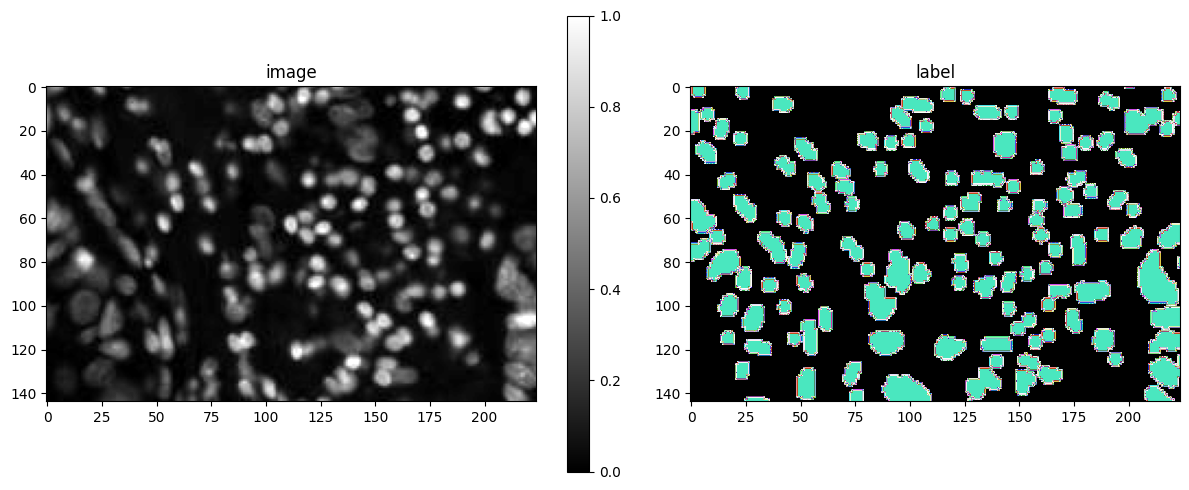

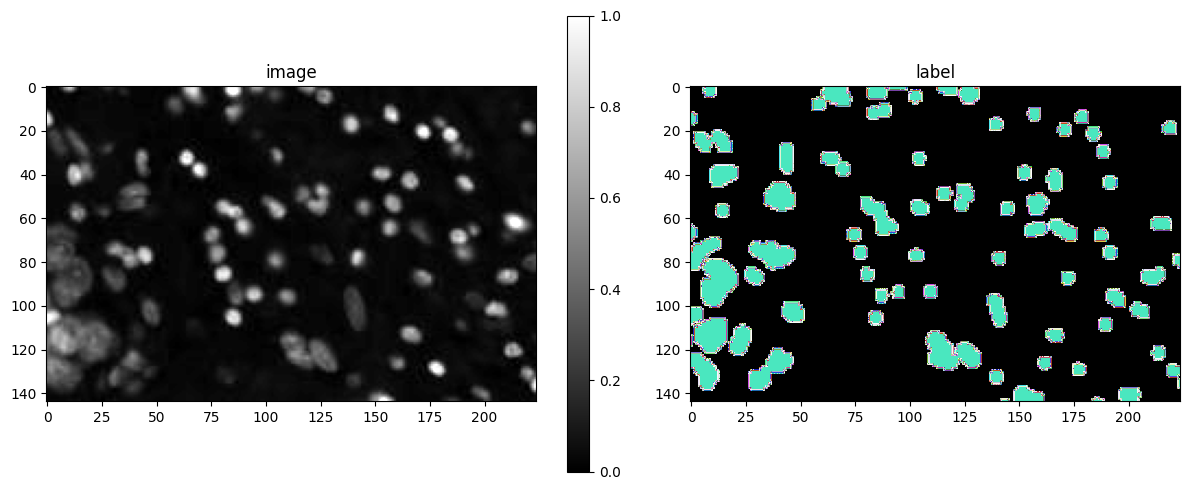

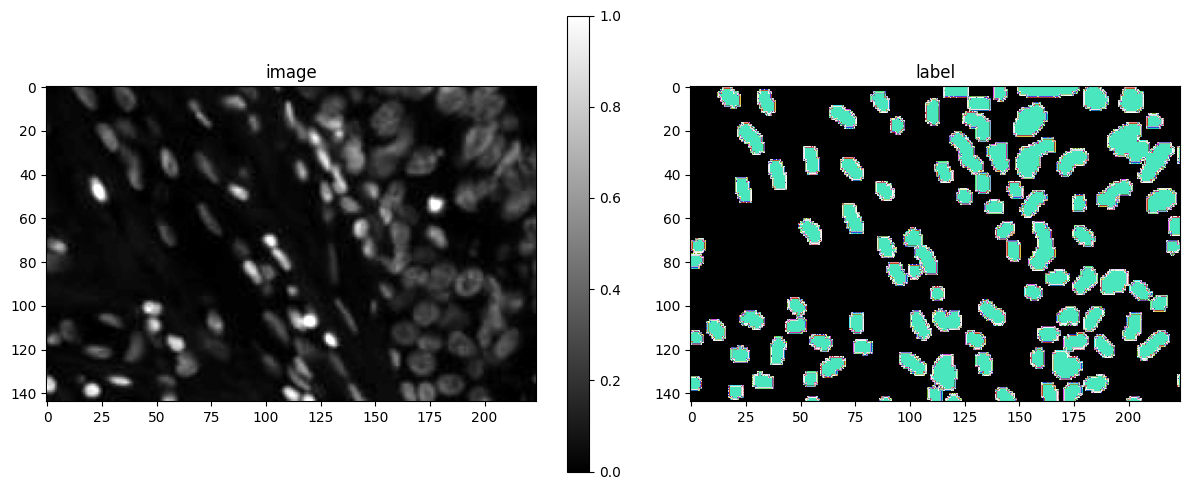

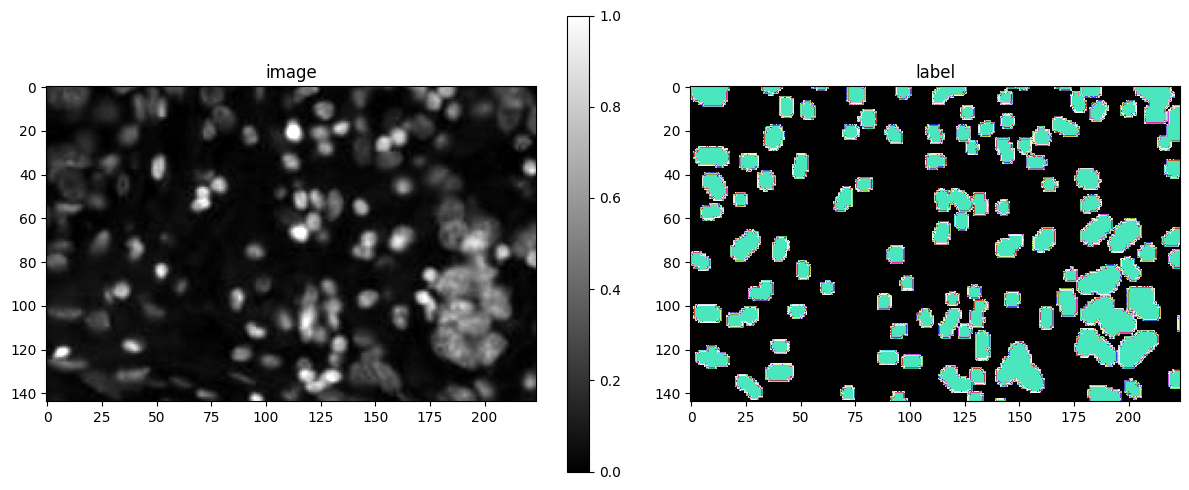

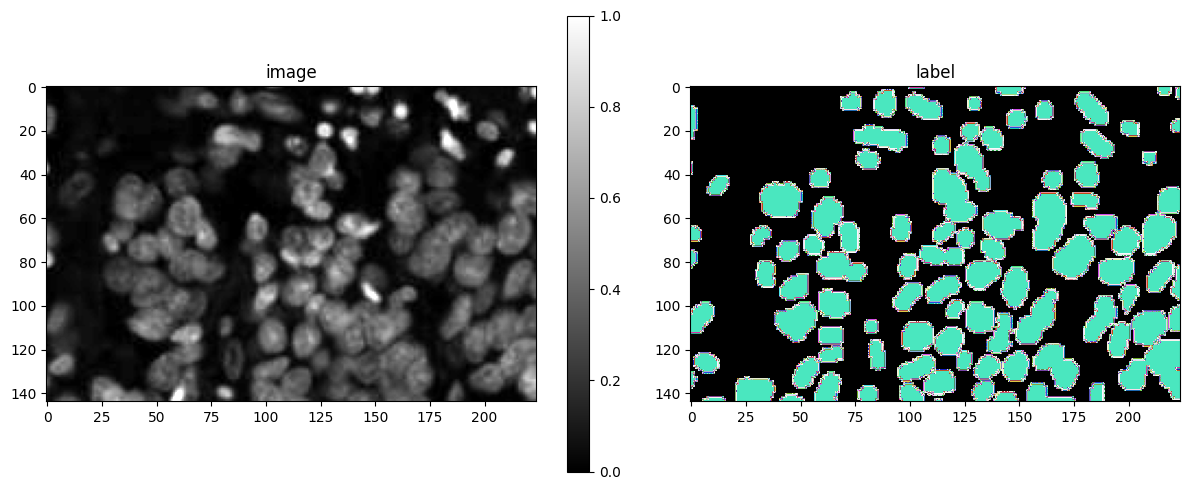

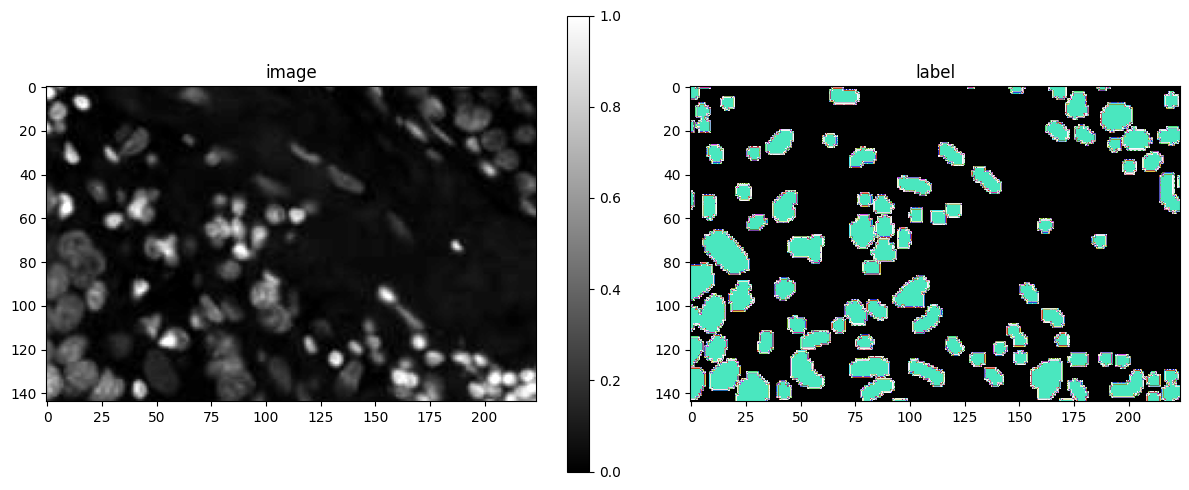

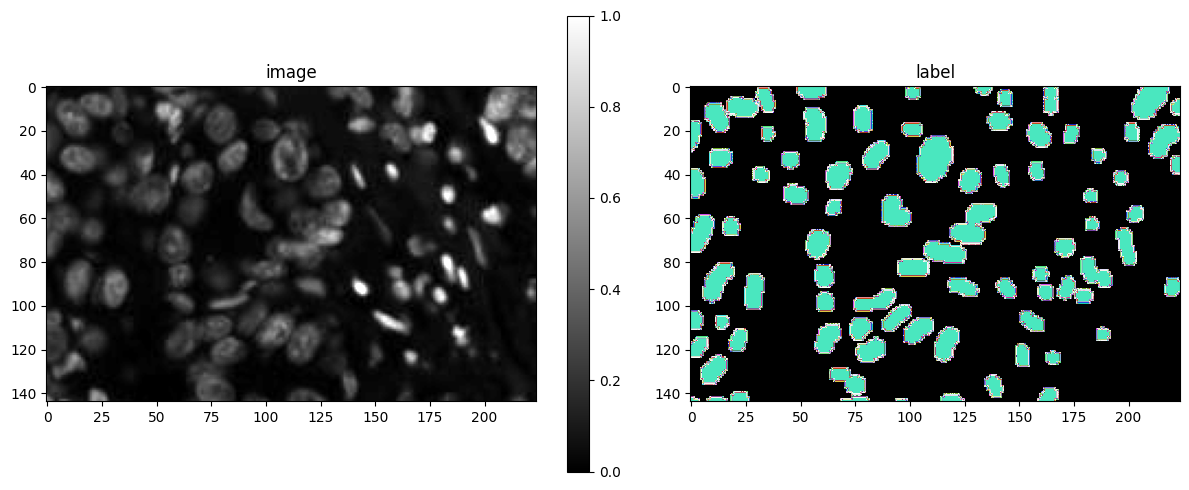

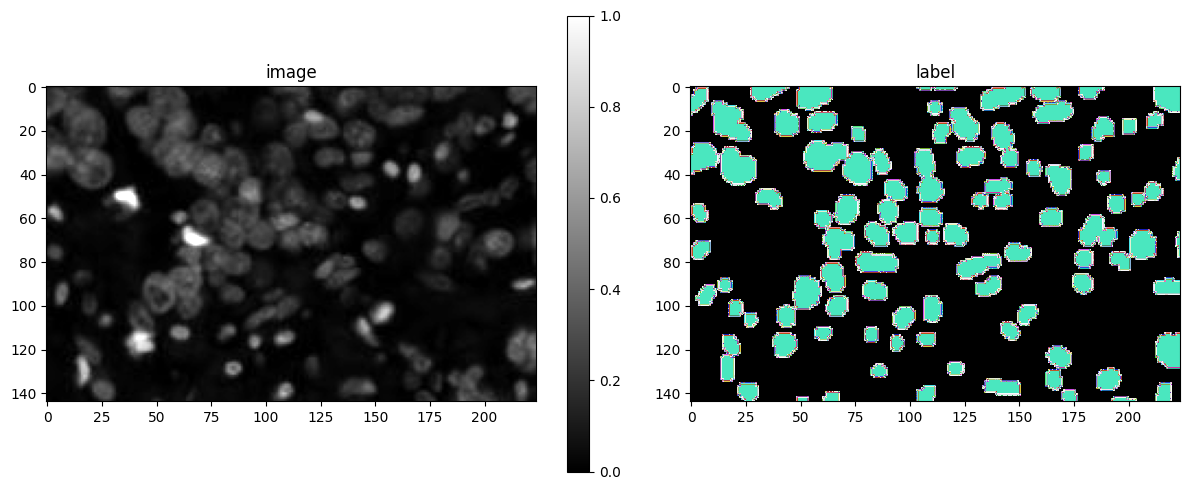

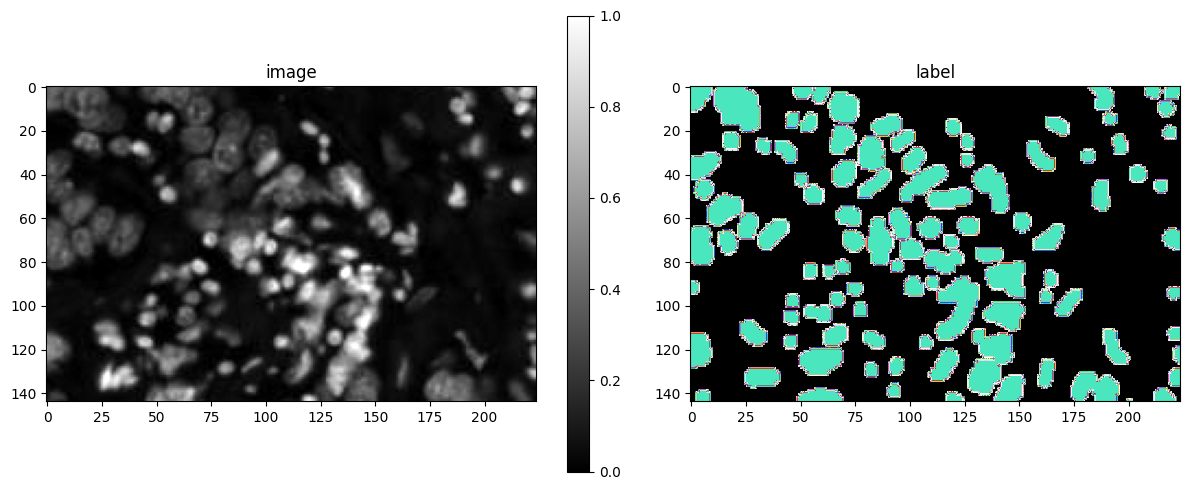

In [9]:
#PLot image and label for some images - sanity check
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()


i = min(9, len(X)-1)

img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
for index, x in enumerate(X):
    plot_img_label(X[index], Y[index])


In [10]:
#Check config to get an idea about all parameters
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [11]:
#Define the config by setting some parameter values

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_patch_size = (144, 224)
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(144, 224), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (144, 224),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [12]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [13]:
#Save model to the specified directory
model = StarDist2D(conf, name='stardist_tutorial', basedir='/content/drive/MyDrive/Colab Notebooks/models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [14]:
#Define the network field of view to size larger than the median object size
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")


median object size:      [144. 224.]
network field of view :  [93 94]


In [15]:
#Define a few augmentation methods
def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

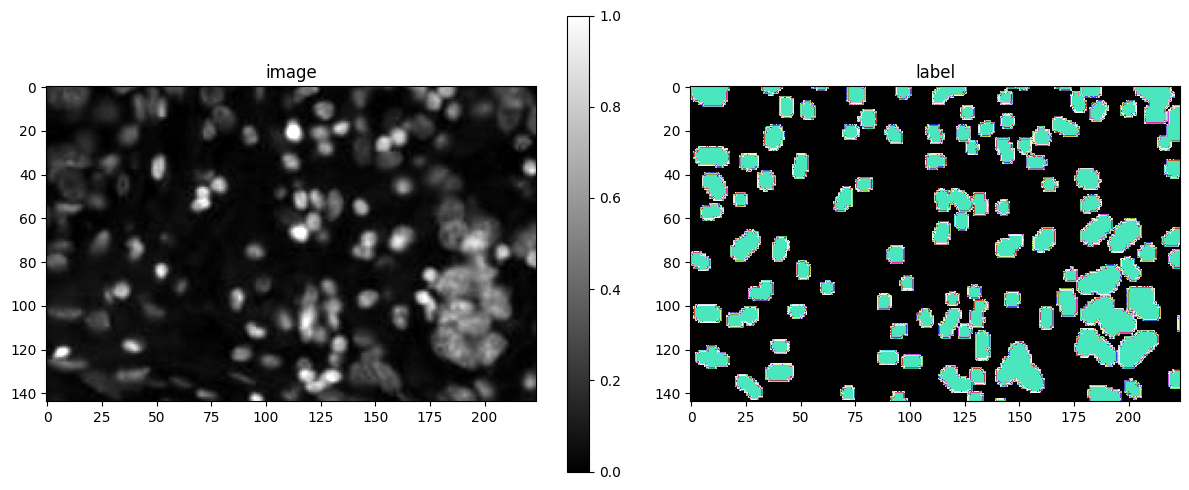

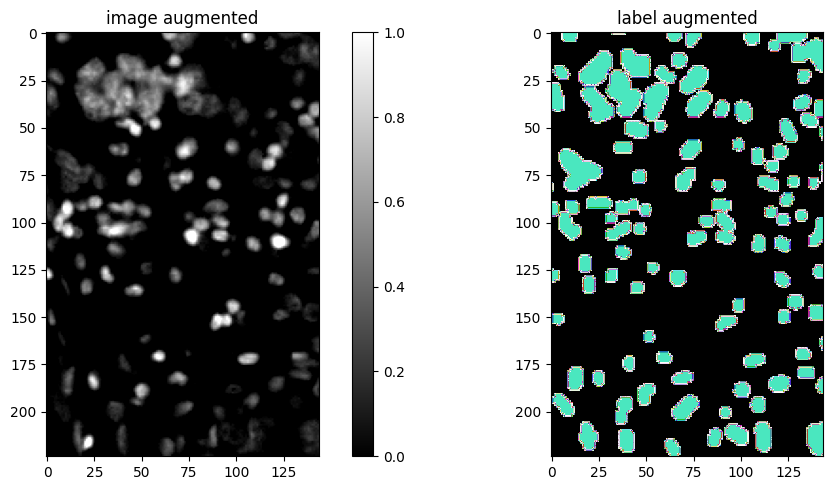

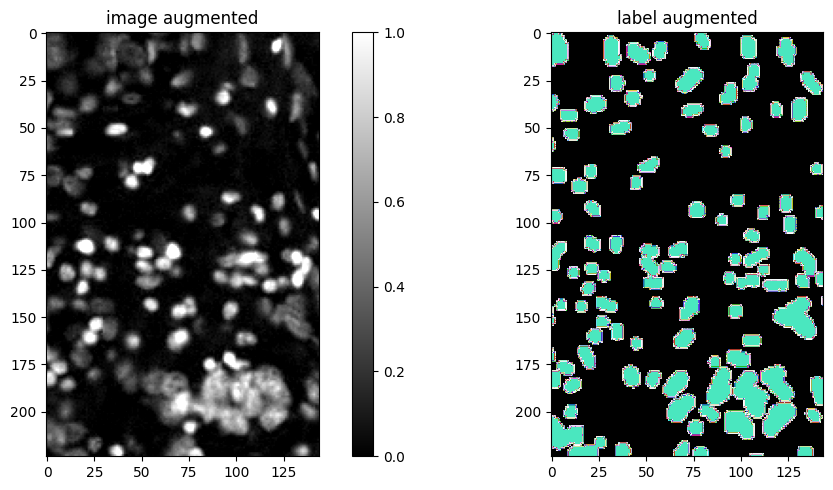

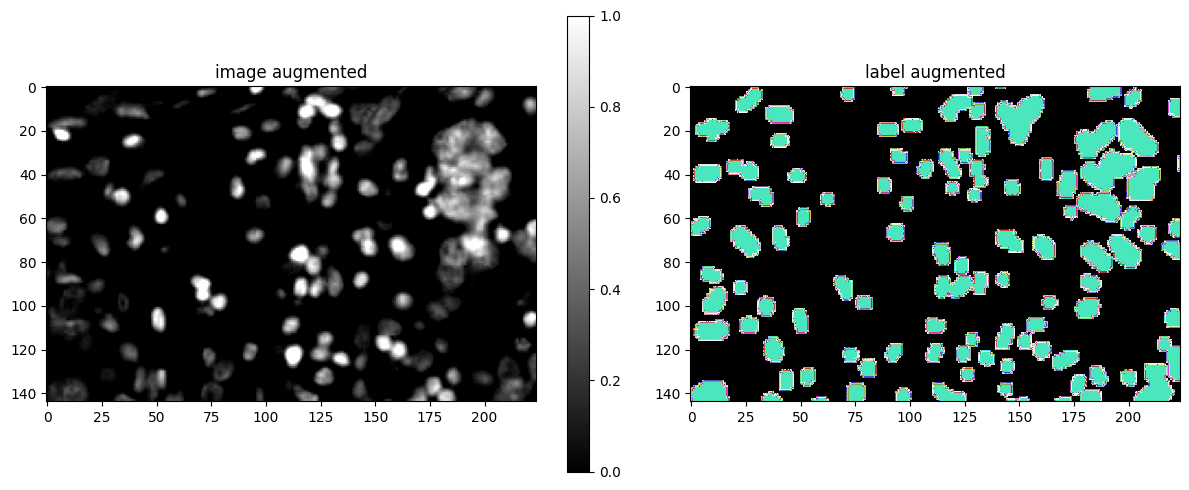

In [16]:

# plot some augmented examples
img, lbl = X[3],Y[3]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")


In [17]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), epochs=10, steps_per_epoch=100)

Epoch 1/10


Cause: Unable to locate the source code of <function _gcd_import at 0x7ea9d36a7400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7ea9d36a7400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 19s 66ms/step - loss: 1.0213 - prob_loss: 0.3165 - dist_loss: 3.5244 - prob_kld: 0.1821 - dist_relevant_mae: 3.5241 - dist_relevant_mse: 22.5665 - dist_dist_iou_metric: 0.2025 - val_loss: 0.7577 - val_prob_loss: 0.2551 - val_dist_loss: 2.5129 - val_prob_kld: 0.1361 - val_dist_relevant_mae: 2.5125 - val_dist_relevant_mse: 11.3067 - val_dist_dist_iou_metric: 0.3467 - lr: 3.0000e-04
Epoch 2/10
100/100 [==============================] - 

In [18]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  15%|█▌        | 3/20 [00:00<00:00, 84.03it/s, 0.798 -> 0.000]


Using optimized values: prob_thresh=0.399047, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.39904677867889404, 'nms': 0.3}

In [20]:
#Load saved model
my_model = StarDist2D(None, name='stardist_tutorial', basedir='/content/drive/MyDrive/Colab Notebooks/models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.399047, nms_thresh=0.3.


In [21]:
model=my_model

In [22]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


100%|██████████| 9/9 [00:00<00:00, 182.49it/s]


DatasetMatching(criterion='iou', thresh=0.5, fp=36, tp=0, fn=1, precision=0, recall=0, accuracy=0, f1=0, n_true=1, n_pred=36, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False)

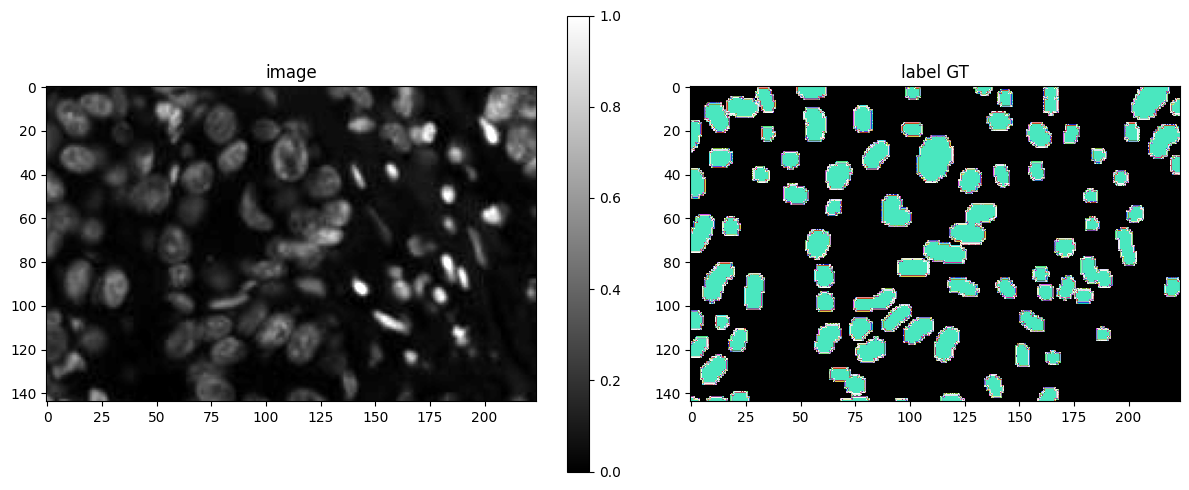

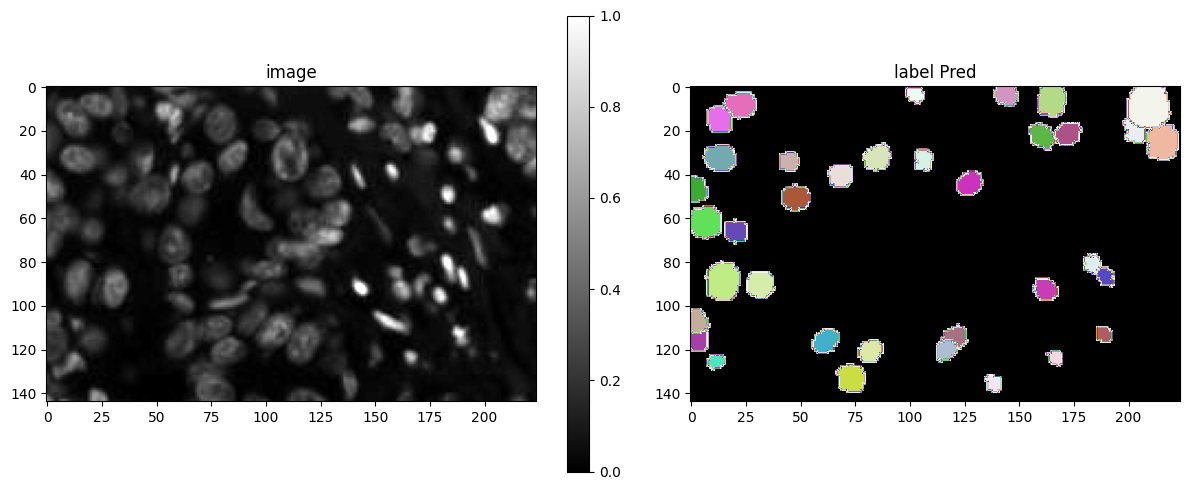

In [23]:
#PLot original labels and predcitions
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]






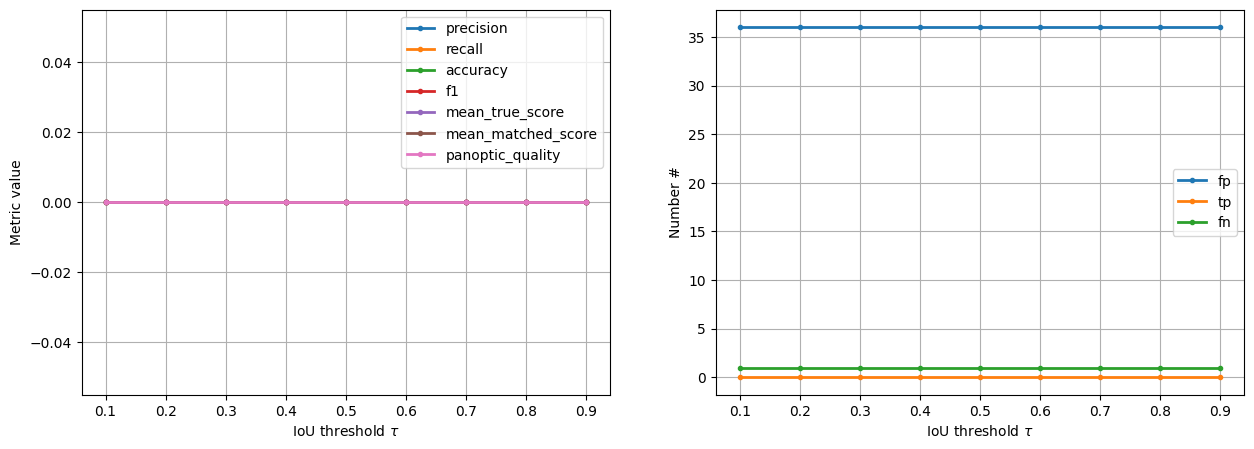

In [24]:
#Plot key metrics
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

